## Sequential Data Prediction using RNN
#### Going to predict using trig functions

In [205]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [206]:
t = np.arange(0, 200, 0.1); print(len(t))

2000


In [207]:
def trig_function(t):
    temp_sin = 3 * np.power(np.sin(t),9)
    temp_cos = 2 * np.power(np.cos(t),9)
    r = np.random.rand(len(t))
    return temp_sin + temp_cos + 2*r

In [208]:
trig_data_original = trig_function(t)

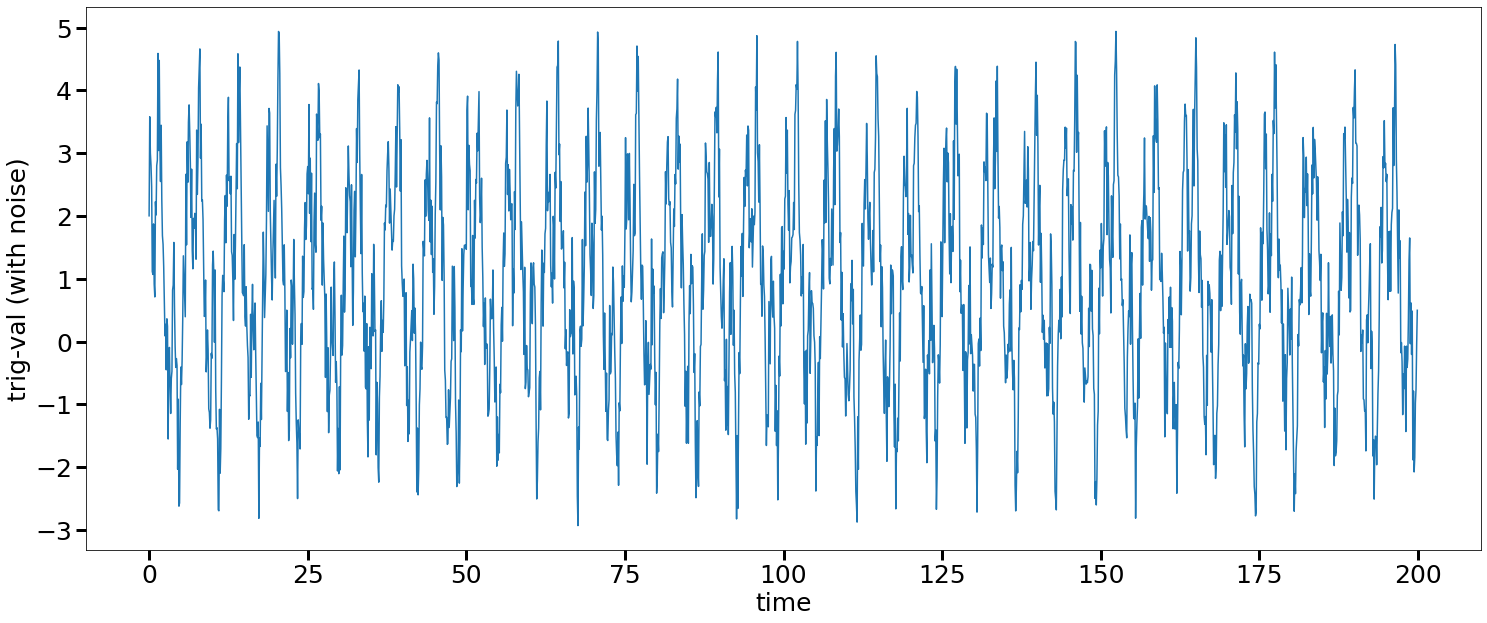

In [209]:
plt.figure(figsize=(25,10))
#plt.scatter(t, trig_data, marker='x')
plt.plot(t, trig_data_original)
plt.tick_params(axis='both', which='major', labelsize=25,length=10,width=3)
plt.xlabel(xlabel='time', size='25')
plt.ylabel(ylabel='trig-val (with noise)', size='25')
plt.show()

## Single Step Model: Predicts One data point into future

### Making appropriate training, testing data

> probably the most important part out of all this.

In [210]:
trig_data = np.copy(trig_data_original)

In [211]:
trig_series = pd.Series(data=trig_data, index=t, name="Trig Data")
train_end_index = int(len(trig_series) * 0.8); train_end_index

1600

In [212]:
# code directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [213]:
# time to scale these features and standardize using training data

train_data_mean = trig_data[:train_end_index].mean()
train_data_std = trig_data[:train_end_index].std()
print(train_data_mean, train_data_std)
trig_data = (trig_data - train_data_mean)/train_data_std

1.0085127438668193 1.6531260920438793


In [214]:
# past 30 trig data vals will be used to predic 31st val
trig_past_history = 20
trig_future_target = 0

x_train_trig, y_train_trig = univariate_data(trig_data, 0, train_end_index, trig_past_history, trig_future_target)

x_test_trig, y_test_trig = univariate_data(trig_data, train_end_index, None, trig_past_history, trig_future_target)

(2000,)